Connect Google-Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Install YOLOv5

In [2]:
%cd /content/

/content


In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16066, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 16066 (delta 2), reused 3 (delta 0), pack-reused 16056
Receiving objects: 100% (16066/16066), 14.68 MiB | 22.07 MiB/s, done.
Resolving deltas: 100% (11030/11030), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


Import Dataset

In [5]:
%cd /content/yolov5

/content/yolov5


In [6]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="39jVZkEobrUXpYD6x46n")
project = rf.workspace("michael-kravtchenko-5luwb").project("kugelschreiberdetection")
dataset = project.version(2).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existing 

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to KugelschreiberDetection-2 in yolov5pytorch:: 100%|██████████| 244/244 [00:00<00:00, 9990.34it/s]


Configure Model

In [7]:
%cd /content/yolov5

/content/yolov5


In [8]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/yolov5/KugelschreiberDetection-2/data.yaml

names:
- feder
- oben-kugel
- patrone
- unten-kugel
nc: 4
roboflow:
  license: CC BY 4.0
  project: kugelschreiberdetection
  url: https://universe.roboflow.com/michael-kravtchenko-5luwb/kugelschreiberdetection/dataset/2
  version: 2
  workspace: michael-kravtchenko-5luwb
test: ../test/images
train: KugelschreiberDetection-2/train/images
val: KugelschreiberDetection-2/valid/images


In [9]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [10]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [11]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [12]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

Train Model

In [16]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 16 --epochs 300 --data /content/yolov5/KugelschreiberDetection-2/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-11-20 11:20:40.755212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 11:20:40.755289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 11:20:40.755337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-20 11:20:41.782587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/KugelschreiberDetection-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False,

# Predict Data

In [18]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source /content/yolov5/KugelschreiberDetection-2/test/images --save-txt

/content/yolov5
detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/yolov5/KugelschreiberDetection-2/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
image 1/5 /content/yolov5/KugelschreiberDetection-2/test/images/Video1_10_jpg.rf.2a120ccfa047c068fa172fb52fd3f350.jpg: 416x416 1 feder, 1 oben-kugel, 1 patrone, 1 unten-kugel, 8.1ms
image 2/5 /content/yolov5/KugelschreiberDetection-2/test/images/Video1_20_jpg.rf.f395a87a1d52

Print Captcha

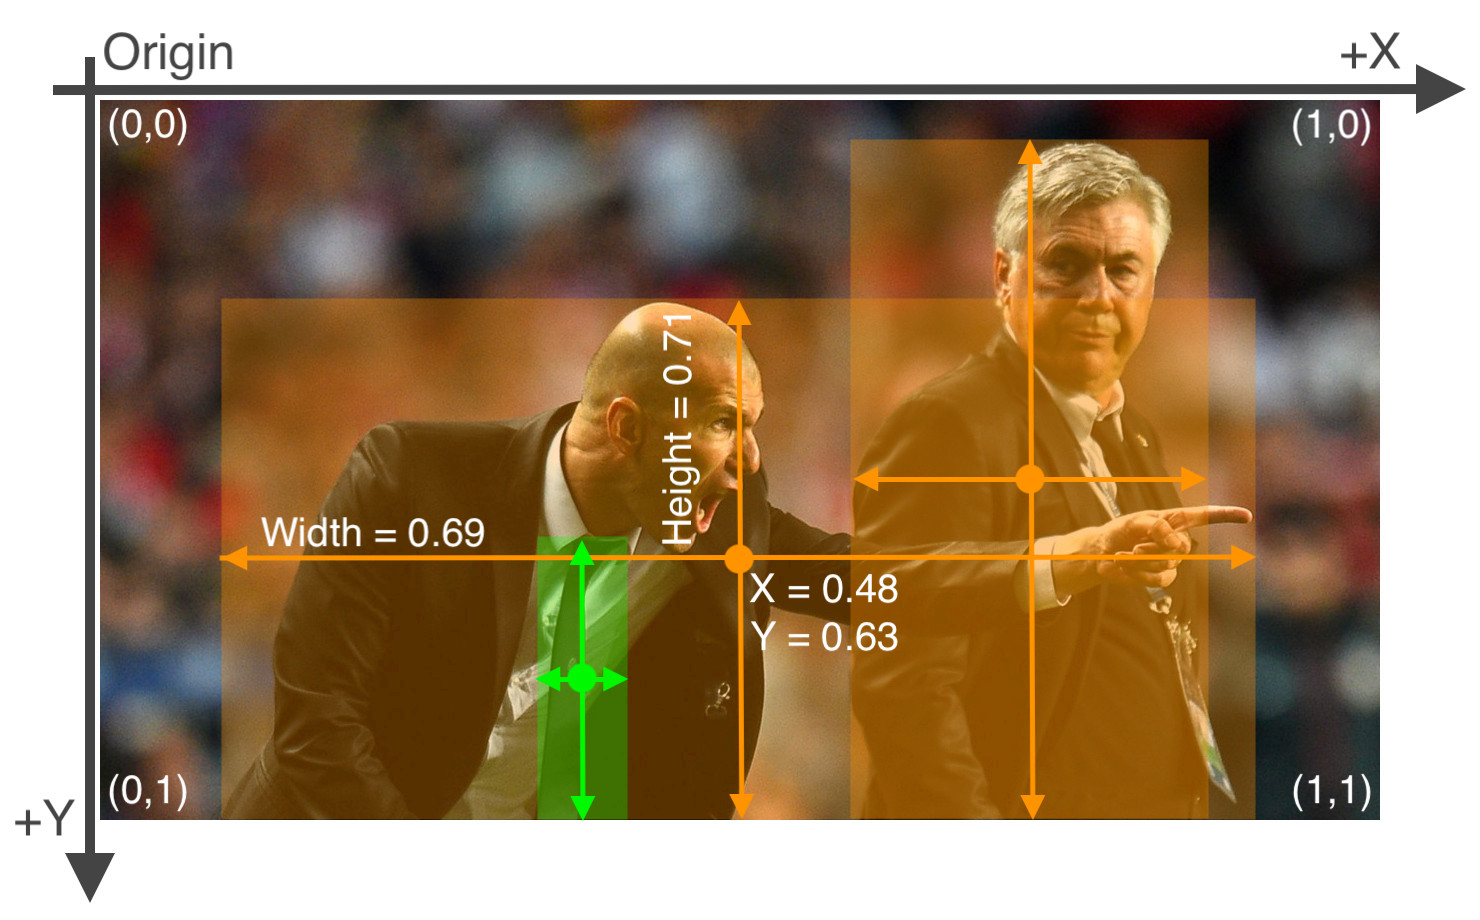

**Structure in -save_txt: class x_center y_center width height**

*Print* Captcha (Ab hier nur für Captchas)

In [ ]:
import os
import shutil

def sort_and_extract_first_value(filename):
    values = []
    with open(filename, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.split()
        third_value = float(parts[1])
        first_value = int(parts[0])
        values.append((first_value, third_value))

    sorted_values = sorted(values, key=lambda x: x[1])

    sorted_first_values = [val[0] for val in sorted_values]
    captcha_str = ''.join(map(str, sorted_first_values))
    # print(captcha_str)

    # Extrahiere die Ziffer vor .txt
    file_number = os.path.basename(filename).split('.')[0]
    # print(file_number)

    # Vergleiche die Ziffer vor .txt mit der letzten Ziffer im Captcha
    if file_number == captcha_str:
        verification = "correct"
    else:
        verification = "false"

    print(f"Captcha for {os.path.basename(filename)}: {captcha_str}")
    #print(f"Captcha for {os.path.basename(filename)}: {captcha_str} - Verification: {verification}")

    return verification

directory = '/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/runs/detect/exp30/labels'
zielpfad_images = '/content/NewData3/images'
zielpfad_labels = '/content/NewData3/labels'
correct_count = 0
false_count = 0

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        file_path = os.path.join(directory, filename)
        result = sort_and_extract_first_value(file_path)

        if result == "correct":
            correct_count += 1
            #shutil.copy(f'/content/gdrive/MyDrive/Projects/Dev/Captchas/Captchas5/{filename.split(".")[0]}.jpg', zielpfad_images)
            #shutil.copy(f'/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/runs/detect/exp22/labels/{filename}', zielpfad_labels)
        else:
            false_count += 1

score = correct_count / (correct_count + false_count)

#print()
#print(f"Number of correct verifications: {correct_count}")
#print(f"Number of false verifications: {false_count}")
#print(f"Score: {score}")

Captcha for 0.txt: 32256
Captcha for 1.txt: 61732
Captcha for 10.txt: 95563
Captcha for 11.txt: 42625
Captcha for 12.txt: 50784
Captcha for 13.txt: 50551
Captcha for 14.txt: 37275
Captcha for 16.txt: 74892
Captcha for 17.txt: 25170
Captcha for 18.txt: 35223
Captcha for 19.txt: 98035
Captcha for 3.txt: 23628
Captcha for 4.txt: 79344
Captcha for 5.txt: 22393
Captcha for 6.txt: 31625
Captcha for 7.txt: 77452
Captcha for 8.txt: 62369
Captcha for 9.txt: 25276


In [ ]:
%cd content

/content


In [ ]:
!unzip CaptchasForMischa -d /content/

Archive:  CaptchasForMischa.zip
   creating: /content/CaptchasForMischa/
  inflating: /content/__MACOSX/._CaptchasForMischa  
  inflating: /content/CaptchasForMischa/8.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._8.jpg  
  inflating: /content/CaptchasForMischa/9.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._9.jpg  
  inflating: /content/CaptchasForMischa/14.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._14.jpg  
  inflating: /content/CaptchasForMischa/17.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._17.jpg  
  inflating: /content/CaptchasForMischa/16.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._16.jpg  
  inflating: /content/CaptchasForMischa/12.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._12.jpg  
  inflating: /content/CaptchasForMischa/13.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._13.jpg  
  inflating: /content/CaptchasForMischa/11.jpg  
  inflating: /content/__MACOSX/CaptchasForMischa/._11.jpg  
  infl

In [ ]:
import os
import random
import shutil

# Pfade zu den Ordnern
root_folder = "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData2"  # Ersetze "Pfad/zum/Hauptordner" durch den tatsächlichen Pfad
images_folder = os.path.join(root_folder, "images")
labels_folder = os.path.join(root_folder, "labels")

# Neue Ordner erstellen
train_folder = os.path.join(root_folder, "train")
val_folder = os.path.join(root_folder, "validation")
test_folder = os.path.join(root_folder, "test")

for folder in [train_folder, val_folder, test_folder]:
    os.makedirs(os.path.join(folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(folder, "labels"), exist_ok=True)

# Dateinamen aus den Ordnern "images" und "labels" erhalten
image_files = os.listdir(images_folder)
label_files = os.listdir(labels_folder)

# Sicherstellen, dass für jede Bild-Datei eine entsprechende Text-Datei vorhanden ist
image_files = [file for file in image_files if file.replace(".jpg", ".txt") in label_files]

# Zufällige Reihenfolge der Dateien
random.shuffle(image_files)

# Aufteilung der Daten
total_files = len(image_files)
train_split = int(0.7 * total_files)
val_split = int(0.15 * total_files)

# Verteilung der Dateien in die entsprechenden Ordner
for i, file in enumerate(image_files):
    source_img = os.path.join(images_folder, file)
    source_txt = os.path.join(labels_folder, file.replace(".jpg", ".txt"))

    if i < train_split:
        destination_folder = train_folder
    elif i < train_split + val_split:
        destination_folder = val_folder
    else:
        destination_folder = test_folder

    dest_img = os.path.join(destination_folder, "images", file)
    dest_txt = os.path.join(destination_folder, "labels", file.replace(".jpg", ".txt"))

    shutil.copyfile(source_img, dest_img)
    shutil.copyfile(source_txt, dest_txt)


Merge

In [ ]:
!mv "/content/NewData3" "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData"

In [ ]:
!zip -r /content/NewData3.zip /content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80310.jpg (deflated 4%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80371.jpg (deflated 6%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80453.jpg (deflated 3%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80517.jpg (deflated 3%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80520.jpg (deflated 4%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80543.jpg (deflated 5%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80555.jpg (deflated 4%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80705.jpg (deflated 3%)
  adding: content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData3/images/80722.jpg (deflated 2

In [ ]:
!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/test/images/" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/test/images"
!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/test/labels/" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/test/labels"

!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/train/images/" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/train/images"
!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/train/labels/" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/train/labels"

!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/validation/images/" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/valid/images"
!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/validation/labels/" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/valid/labels"

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [ ]:
!mv "/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/test/images/*" "/content/gdrive/MyDrive/Projects/Dev/Captchas/yolov5/CaptchasLight-3/test/images"

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
mv: cannot stat '/content/gdrive/MyDrive/Projects/Dev/Captchas/TestData/NewData/test/images/*': No such file or directory
